# Introduction and Business Problem

 * Name: Amelia Dobronyi
 * Instructor: Abhineet Kulkarni
 * Pace: Flex

In this notebook, I will be performing data analysis and linear regression on a data set from King's County. The data is home sale prices and relevant home information. The goal of the analysis is to build a linear regression model that explains the sale prices for homes in King's County using various attributes. The stakeholder for this business problem is an independent real estate investor, who buys homes and invests in them to sell them for a netted profit.

# Data Exploration

In [8]:
# import packages

import pandas as pd
import numpy as np
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
#plt.style.use('seaborn')

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
# import data
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [10]:
# get data dimensions
df.shape

(21597, 21)

In [11]:
# observe types of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

From the above descriptions, the data is a set of 21,597 observed home sale prices, and 20 attributes of the sale (19 if you disregard the sale ID). The data types are either numeric or descriptive - those that are not numeric and deemed relevant will have to be transformed to categorical variables.

# Data Preparation

Though we already know that the data will have to be pre-processed for inclusion in the linear model, looking at potential missing values is a good place to start because how we decide to deal with missing values will determine in part how we go about processing the data. 

In [12]:
# count missing values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

From this table, we can see that missing values are confined to three variables: waterfront, view, and renovation year. Because these are all intuitively important variables, we should not deal with the missing values by simply not including these variables as important predictors. Moreover, because the number of missing values for waterfront and renovation year are sizeable, we should not necessary simply exclude these observations - especially as the fact of missingness might have some explanatory value. For the missing values of view, however, we will go ahead and exclude those observations because the number of missing values is relatively small compared to the size of the overall dataset.

In [13]:
# drop rows with missing value of 'view' predictor
df = df.dropna(subset=['view'])
df.shape

(21534, 21)

## Numerical Data

Now we need to go through the dataset and examine the relationships between each independent variable and the dependent variable, sale price. Before we do this however, we can begin by looking en masse at the relationship between just the numeric variables and sale price.

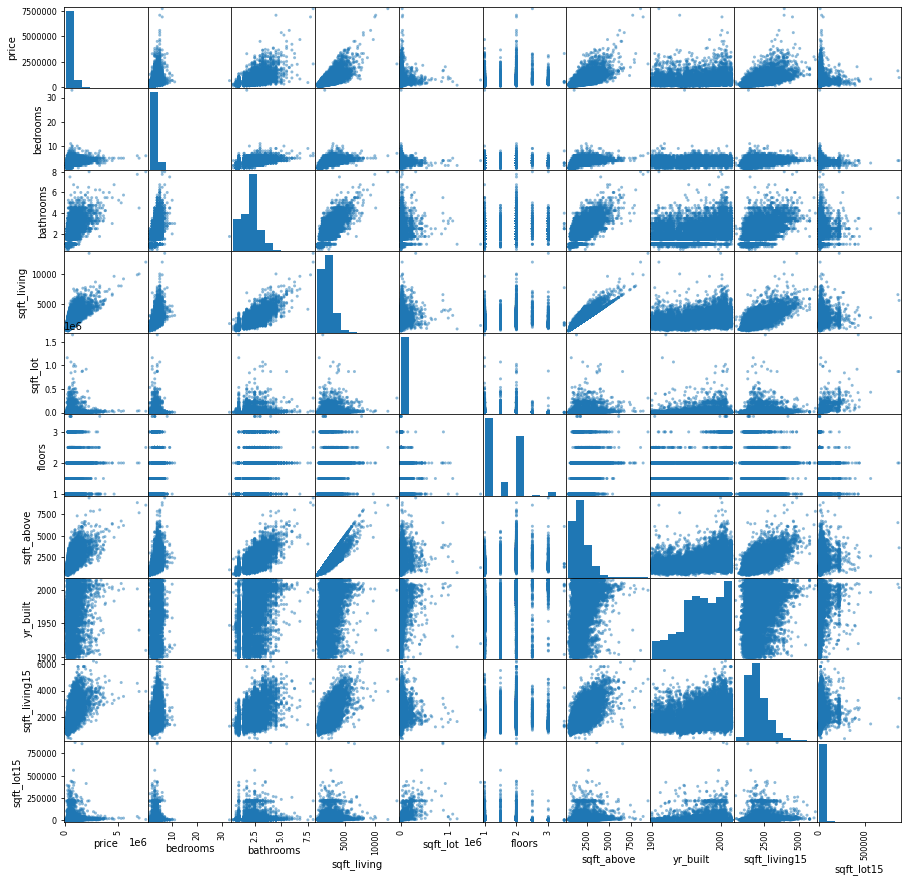

In [14]:
# subset numeric variables to observe direction relationship to sale price
numeric = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement',
           'yr_built','sqft_living15','sqft_lot15']
pd.plotting.scatter_matrix(df[numeric], figsize=(15,15));

The above plot is useful for a few considerations that can provide a strong start for data processing and analysis. Importantly, this is just numerical predictors - we have not even begun to look at the explanatory value that categorical variables might provide. But the scatter plot does have some immediate takeaways:

1. The price variable itself does not appear to be normally distributed (and neither do some predictors) - before we even beginning evaluating models, we might have to consider either transforming the price variable or dropping some outlying observations.

2. While most of the variables in the plot show some (largely positive relationships), there are a couple at first glance that clearly do not - square footage of the lot and year built, for example. We will probably not consider including these variables in an early version of the model, if at all.

3. The square foot of living space and square foot of space above the basement variables seem to have a very strong linear relationship - it looks for some observations that they are almost identical. This is a strong indication of multicollinearity, and going forward we will probably only consider including one of these variables in the model, if at all.

4. The differing scales of the independent variables suggest that data normalization or scaling might be useful. Though this will likely improve the overall reliability of the model, it means that train/test splitting might be a better approach for model validation, because performing so many transformations in a cross-validation context will be too computationally intensive.

Additionally, it is important to note that the geographic data - zip code, latitude, or longitude - was considered numeric in this context. Though location probably does have some bearing on home price, the problem with treating this data as numeric is that it is not necessarily linear with home price, i.e. areas with higher zip codes may not have higher sale prices, even if it does impact the price in some other way (better school district, for example). Therefore, we will have to consider how else it might make sense to include locationd data in the model.

Now we can go through some of the variables individually and make observations or decide on transformations that might be useful for creating a strong model from the outset. In order to track any changes or transformations we make to variables, we should create a new dataframe to store those updates.

In [15]:
# copy dataframe to hold updated variables
df_new = df.copy()
df_new.shape

(21534, 21)

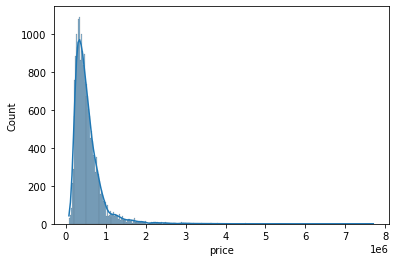

In [16]:
# histogram of price (DEPENDENT) variable
sns.histplot(df['price'],kde=True);

The histogram of price, the dependent variable, suggests that it would be a good candidate for log transformation - as the number of homes with higher sale prices drops off considerably with price itself.

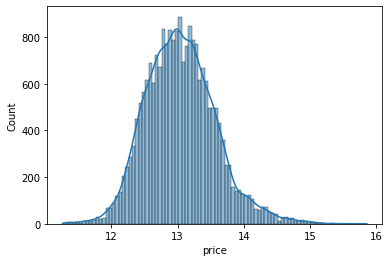

In [17]:
# histogram of price (DEPENDENT) variable with log transformation
sns.histplot(np.log(df['price']),kde=True);

Though the price variable with the log transformation is not perfectly normally distributed, it is visibly much closer to that with the data having been logged transformed. Before proceeding, it makes sense to run a single model as a baseline example. This way, whenever we are questioning if a certain transformation or addition will positively alter the model, we have something to refer to. 

In [18]:
# create new log_price column
df_new['log_price'] = np.log(df_new['price'])
df_new.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,12.309982
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,13.195614
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,12.100712
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,13.311329
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,13.142166


In [19]:
# examine number of bedrooms
df['bedrooms'].describe()

count    21534.000000
mean         3.373038
std          0.926410
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

In [20]:
# max number of bedrooms looks like an outlier - examine table of values for more context
df['bedrooms'].value_counts().sort_index()

1      196
2     2754
3     9791
4     6865
5     1596
6      270
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [21]:
# since 33 bedrooms is an obvious outlier, we will remove that observation from the data set
df_new = df_new[df_new['bedrooms'] <= 11]
df_new.shape

(21533, 22)

count    21534.000000
mean         2.115712
std          0.768602
min          0.500000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64


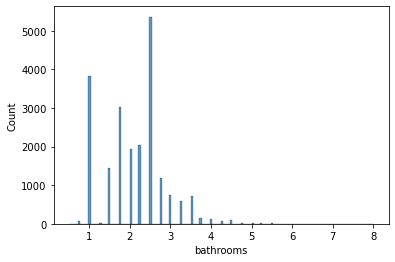

In [22]:
# repeat above for bathrooms
print(df['bathrooms'].describe())
sns.histplot(df['bathrooms']);

Even though the bathrooms data is not normally distributed, in absolute terms, it does not appear that the distribution of bathrooms is so large, and it is not clear what kind of transformation should be performed on the data to improve it.

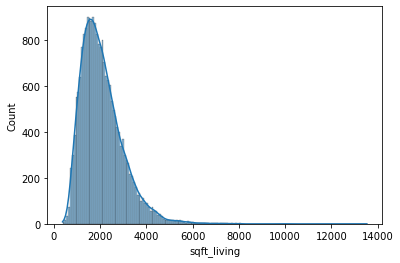

In [23]:
# histogram of square foot of living
sns.histplot(df['sqft_living'],kde=True);

Here we see a similar distribution to price - a log transformation should help the data here appear more normal.

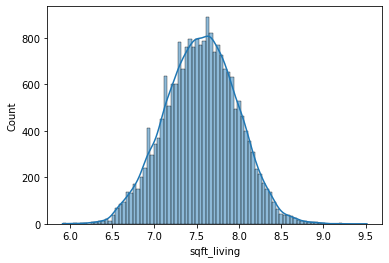

In [24]:
# histogram of log transformed square foot of living 
sns.histplot(np.log(df['sqft_living']),kde=True);

Though there is still the appearance of a small upper tail here, the log transformation clearly suits the original distribution of living space square foot. We can replace the data, and since we know that the data for square footage above ground is very similarly distributed, we will go ahead and replace that data as well.

In [25]:
# create new log transformation columns for sqft_living and sqft_above
df_new['log_sqft_living'] = np.log(df_new['sqft_living'])
df_new['log_sqft_above'] = np.log(df_new['sqft_above'])
df_new.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price,log_sqft_living,log_sqft_above
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1955,0.0,98178,47.5112,-122.257,1340,5650,12.309982,7.073270,7.073270
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,13.195614,7.851661,7.682482
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,1933,NaN,98028,47.7379,-122.233,2720,8062,12.100712,6.646391,6.646391
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1965,0.0,98136,47.5208,-122.393,1360,5000,13.311329,7.580700,6.956545
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1987,0.0,98074,47.6168,-122.045,1800,7503,13.142166,7.426549,7.426549


From the scatter plots above, it seems that both square footage of the lot and number of floors have very weak, if any, linear relationships with sale price. For that reason, we will disregard those for now, and perhaps consider re-visiting later. The same is true of year built. There is likely some value in looking more closely at year of renovation, but that will be looked at in the context of missing values first.

The bit of the data we should look at in this context - though it is not numeric - is geographic data. As per above, the geographic data as determined by zip code is likely valuable, because of what the zip code represents - school district, taxes, funding, even reputation.

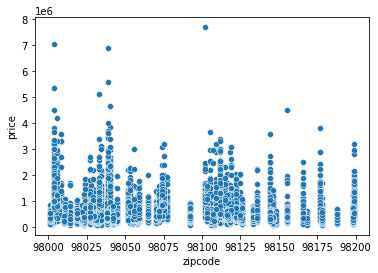

In [26]:
# plot price as a function of zip code
sns.scatterplot(df['zipcode'],df['price']);

As we can see from the scatterplot, some zip codes are clearly associated with higher sale prices than others. However, there is no numerical relationship between the actual zip code and the sale price. For this reason, we should consider looking at the latitude and longitude data provided, which might prove more useful.

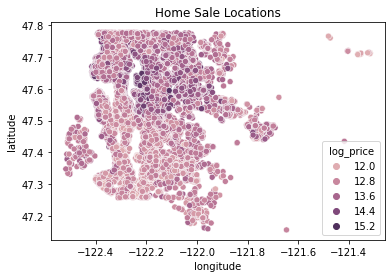

In [27]:
# plot latitude vs longitude - this map is a representative graphic of sale price
sns.scatterplot(df_new['long'],df_new['lat'],hue=df_new['log_price'])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Home Sale Locations');

Since we are looking at latitude vs longitude, we have an actual geographic depiction of the data points. And using coloring by sale price (log transformed, to make the scale more visible) we see that towards the center of the plot there is a higher concentration of darker circles, representing higher sale prices. Since the data points are not evenly distributed in space, we will have to make a somewhat arbitrary division of the data points.

In [28]:
# divide points as above or below midpoint of latitude
mid_lat = np.min(df_new['lat'])+(np.max(df_new['lat']) - np.min(df_new['lat']))/2
df_new['high_lat'] = df_new['lat'].apply(lambda x: 1 if x >= mid_lat else 0)
df_new.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price,log_sqft_living,log_sqft_above,high_lat
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,0.0,98178,47.5112,-122.257,1340,5650,12.309982,7.073270,7.073270,1
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1991.0,98125,47.7210,-122.319,1690,7639,13.195614,7.851661,7.682482,1
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,NaN,98028,47.7379,-122.233,2720,8062,12.100712,6.646391,6.646391,1
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,0.0,98136,47.5208,-122.393,1360,5000,13.311329,7.580700,6.956545,1
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0.0,98074,47.6168,-122.045,1800,7503,13.142166,7.426549,7.426549,1


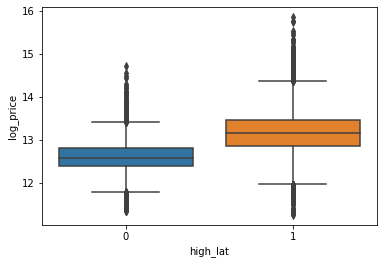

In [25]:
# plot boxplot of latitude distinction
sns.boxplot(df_new['high_lat'],df_new['log_price']);

From the boxplot of latitudes - either above the midpoint or below the midpoint - we see latitude above the midpoint indeed has a higher log sale price. However, as expected from the scatter plot, there is a lot of noise in the latitude distributions themselves, so it remains to be seen how useful this variable could be.

Related to geographic area of the house is the information provided about neighboring houses. Specifically, the data set provides the total square footage of living area and lot area for the nearest 15 properties. From the scatter plot above, it appears that the living area of the nearest 15 houses is more strongly linearly related to sale price. Let's consider it more closely.

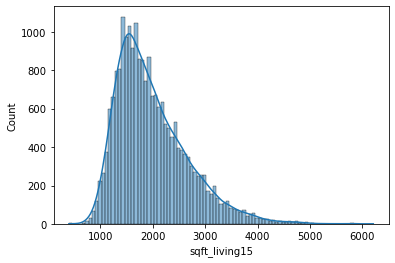

In [26]:
# histogram of square foot of nearest 15 homes
sns.histplot(df['sqft_living15'],kde=True);

As anticipated, this has a similar distribution to the square footage of interior space of single homes - therefore, we will perform the same log transform and consider that this predictor may introduce some multicollinearity should we choose to use it, however it likely does capture some of the necessary geographic data that we will omit by not making use of zip code.

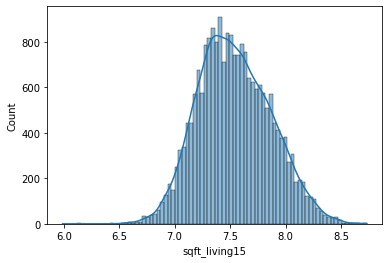

In [27]:
# histogram of log of square foot of nearest 15 homes
sns.histplot(np.log(df['sqft_living15']),kde=True);

In [28]:
# add transformed variable to new dataframe
df_new['log_sqft_living15'] = np.log(df_new['sqft_living15'])
df_new.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,log_price,log_sqft_living,log_sqft_above,high_lat,log_sqft_living15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,98178,47.5112,-122.257,1340,5650,12.309982,7.073270,7.073270,1,7.200425
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,98125,47.7210,-122.319,1690,7639,13.195614,7.851661,7.682482,1,7.432484
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,98028,47.7379,-122.233,2720,8062,12.100712,6.646391,6.646391,1,7.908387
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,98136,47.5208,-122.393,1360,5000,13.311329,7.580700,6.956545,1,7.215240
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,98074,47.6168,-122.045,1800,7503,13.142166,7.426549,7.426549,1,7.495542


## Categorical Variables

Now that numerical variables have been dealt with, we can switch focus to categorical variables, including those with potentially missing data. The first one we will consider is date. To capture the explanatory value within the date variable, we can consider the impact of date by seasons - another way to do this would be looking by year, however that would create an additional 11 variables as opposed to an additional 3.

In [29]:
# extract month from date column
df_new['month'] = df_new['date'].apply(lambda x: x.split('/')[0]).astype(int)
df_new['quarter'] = df_new['month'].apply(lambda x: 1 if x in [1,2,3] else 
                                          (2 if x in [4,5,6] else (3 if x in [7,8,9] else 4)))
df_new.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,log_price,log_sqft_living,log_sqft_above,high_lat,log_sqft_living15,month,quarter
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,-122.257,1340,5650,12.309982,7.073270,7.073270,1,7.200425,10,4
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,-122.319,1690,7639,13.195614,7.851661,7.682482,1,7.432484,12,4
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,-122.233,2720,8062,12.100712,6.646391,6.646391,1,7.908387,2,1
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,-122.393,1360,5000,13.311329,7.580700,6.956545,1,7.215240,12,4
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,-122.045,1800,7503,13.142166,7.426549,7.426549,1,7.495542,2,1


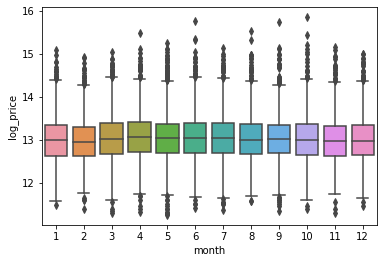

In [30]:
# boxplot of sale price by sale month
sns.boxplot(df_new['month'],df_new['log_price']);

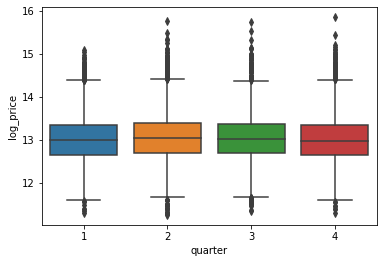

In [31]:
# boxplot of sale price by sale quarter
sns.boxplot(df_new['quarter'],df_new['log_price']);

From the boxplot of log sale price by month of sale, it appears that the median sale price does not fluctuate much by month of sale.

In [32]:
# look at values for waterfront variable
df_new['waterfront'].value_counts()

NO     19018
YES      145
Name: waterfront, dtype: int64

The values that we have for waterfront are 'yes' and 'no'; however we know we also have missing values. From a modeling perspective, the missing values might be informational in themselves, so we should account for them with their own category, which we will replace with the string 'UNKWOWN.'

In [33]:
# replace missing values with 'UNKNOWN'
df_new['waterfront'] = df_new['waterfront'].fillna('UNKNOWN')

In [34]:
# check new valus of waterfront variable
df_new['waterfront'].value_counts()

NO         19018
UNKNOWN     2370
YES          145
Name: waterfront, dtype: int64

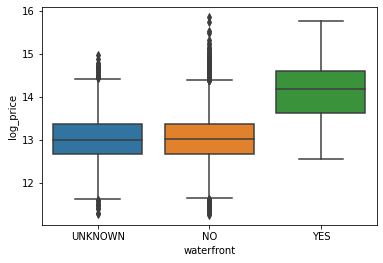

In [35]:
# boxplot of price vs waterfront
sns.boxplot(df_new['waterfront'],df_new['log_price']);

Looking at the previously missing waterfront values, the data suggests that values for waterfront that were missing are actually likely to be 'NO', as they have very similar distributions. However, without any separate knowledge, we have to treat 'UNKNOWN' as its own variable - there is a chance, however, that it will not provide any additional predictive value. From the boxplot, it appears that waterfront properties do in fact yield higher average sale prices.

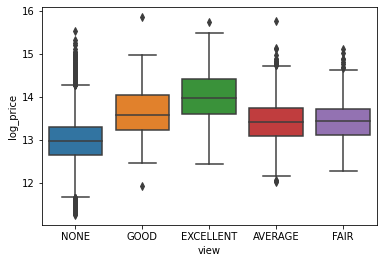

In [36]:
# boxplot of price vs view
sns.boxplot(df_new['view'],df_new['log_price']);

Looking at log price based on view, it does seeem that there is some differentiation among the classes and also in a way that makes sense, i.e. excellent view yields the best average sales price and no view yields the worst.

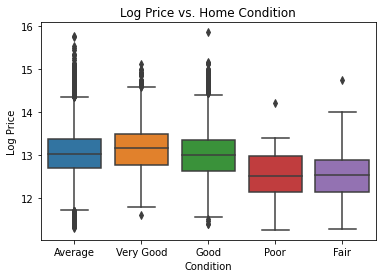

In [44]:
# boxplot of price vs condition
sns.boxplot(df_new['condition'],df_new['log_price']);
plt.xlabel('Condition')
plt.ylabel('Log Price')
plt.title('Log Price vs. Home Condition');

As for differentiation based on condition, it is less obvious here than when considering view, for example, but it may eventually prove to be a useful indicator variable.

In [45]:
# table of values for square footage of basement
df['sqft_basement'].value_counts()

0.0       12798
?           452
600.0       216
500.0       209
700.0       207
          ...  
2196.0        1
374.0         1
768.0         1
248.0         1
1275.0        1
Name: sqft_basement, Length: 302, dtype: int64

When we look at the table of values for basement square footage, which is listed as 'object' in the description, we see the reason for this - what should actually be a numerical value has missing values in the form of '?,' which we can interpret either as missing or perhaps deemed incorrect. Since some kind of imputation would make the most sense to deal with these values, for the moment I think it probably makes more sense to just leave out this predictor - since we should not rely on imputation unless it is highly necessary, and we have enough other predictors - total square footage, square footage of living area, square footage above ground - that should compensate for the explanatory value of this variable.

In [46]:
# table of values for year renovated
df['yr_renovated'].value_counts()

0.0       16961
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [47]:
new = df['yr_renovated']
new.head()

0       0.0
1    1991.0
2       NaN
3       0.0
4       0.0
Name: yr_renovated, dtype: float64

For the year renovated variable, we run into two issues - the first being a high-value count for '0.0,' which suggests a lack of renovation, in addition to the missing values we noted earlier. Again, for the moment I think this variable is probably best left out, at least for initial analysis. The reason for this is that, renovation year should most likely be considered in comparison to the year the house was built, and moreover, if a house was renovated, the value should in theory be captured by the 'condition' variable, assuming the renovation was value-adding. While there is probably more to dig into with this predictor, for the moment we will not consider it.

# Linear Regression Model

## Process Approach to Model

Now that we have gone through all of the data provided, we can start the process of iteratively constructing linear models. To do this, I will start with building a simple linear model with one independent variable, and continue to add variables with the purpose of strengthening the predictive power of the model. 

In doing so, there is the need to balance increasing the inferential power of the model while considering that some statistically important variables might be meaningless for the individual investor. For example, the lot size, should it be inferentially important, is not something the individual investor can likely modify - so when adding new variables to the model, it will be important to focus on independent variables that the average real estate investor could actually change.

To this end, independent variables that would be both useful for individual investors and inferential purposes are:
* square footage of living area
* number of bedrooms
* number of bathrooms
* number of floors
* condition
* timing of sale

Independent variables that are unlikely to be useful for an individual investor but, based on analysis above as well as intuition, are likely to be useful for explanatory purposes, are:
* square footage of the lot
* waterfront property
* property view
* square footage of basement
* location

The metric used to determine inferential power of the model will be *R$^2$*, which is the percentage of variability in the dependent variable that can be explained by the model. Since the purpose of this model is to explain sale prices, and not predict them, *R$^2$* is a sufficient metric. For the final model, I will target *R$^2$* to be in the range of 0.6 to 0.7. Additionally, all of the final variables in the model should be statistically significant - even if they add explanatory value to the model, statistically signiciant variables increase the overall significance of the model.

Once a model that appears to balance both explanatory value and offers variables that can be manipulated via real estate investment, that model will need to be analyzed to make sure it meets the assumptions of linear models.

## Model Iterations

In [50]:
# import packages for linear models
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [51]:
# MODEL 1: price ~ sqft_living
# variable selection based on correlation in table above, as well as intuition
formula = 'price ~ sqft_living' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 2.087e+04
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:01:10   Log-Likelihood:            -2.9911e+05
No. Observations:               21533   AIC:                         5.982e+05
Df Residuals:                   21531   BIC:                         5.982e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.218e+04   4404.621     -9.575      0.000   -5.08e+04   -3.35e+04
sqft_living   279.9379      1.938    144.475      0.000     276.140     283.736
==============================================================================
Omnibus:                    14581.827   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           516123.571
Skew:                           2.781   Prob(JB):                         0.00
Kurtosis:                      26.331   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For a simple (i.e. single independent variable) linear model, this first one is solid. Though the *R$^2$* value for the model is too low for it to be considered sufficient for business purposes, it is a strong start, with a single (though highly relevant variable) able to explain roughly 50% of variability in the model. 

As we look to add further variables, I will try adding number of bathrooms and number of bedrooms incrementally.

In [52]:
# MODEL 2: price ~ sqft_living + bedrooms
formula = 'price ~ sqft_living + bedrooms' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                 1.111e+04
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:01:12   Log-Likelihood:            -2.9877e+05
No. Observations:               21533   AIC:                         5.975e+05
Df Residuals:                   21530   BIC:                         5.976e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    9.349e+04   6757.914     13.835      0.000    8.02e+04    1.07e+05
sqft_living   316.7030      2.369    133.692      0.000     312.060     321.346
bedrooms    -6.292e+04   2403.746    -26.175      0.000   -6.76e+04   -5.82e+04
==============================================================================
Omnibus:                    14038.925   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           451244.063
Skew:                           2.658   Prob(JB):                         0.00
Kurtosis:                      24.787   Cond. No.                     9.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
# MODEL 3: price ~ sqft_living + bedrooms + bathrooms
formula = 'price ~ sqft_living + bedrooms + bathrooms' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     7411.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:29:54   Log-Likelihood:            -2.9877e+05
No. Observations:               21533   AIC:                         5.975e+05
Df Residuals:                   21529   BIC:                         5.976e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    8.856e+04   7051.546     12.558      0.000    7.47e+04    1.02e+05
sqft_living   311.7840      3.105    100.398      0.000     305.697     317.871
bedrooms    -6.382e+04   2431.518    -26.247      0.000   -6.86e+04   -5.91e+04
bathrooms    8607.1709   3514.251      2.449      0.014    1718.977    1.55e+04
==============================================================================
Omnibus:                    14066.389   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           453600.995
Skew:                           2.665   Prob(JB):                         0.00
Kurtosis:                      24.844   Cond. No.                     9.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With the addition of number of bedrooms and bathrooms to the model, the first thing that stands out is the coefficient for number of bedrooms, which is negative. While the number of bedrooms is statistically significant, we would expect that additional bedrooms should either increase the sale price of the house or have no effect; we would not expect more bedrooms to be a detracting feature.

Before we can justify dropping it however, we should see if adding any other variables helps clarify our direction.

In [44]:
# MODEL 4: price ~ sqft_living + bedrooms + bathrooms + floors
formula = 'price ~ sqft_living + bedrooms + bathrooms + floors' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     5558.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:29:54   Log-Likelihood:            -2.9877e+05
No. Observations:               21533   AIC:                         5.975e+05
Df Residuals:                   21528   BIC:                         5.976e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    8.805e+04   7802.273     11.285      0.000    7.28e+04    1.03e+05
sqft_living   311.7873      3.106    100.394      0.000     305.700     317.875
bedrooms    -6.378e+04   2444.361    -26.093      0.000   -6.86e+04    -5.9e+04
bathrooms    8379.7074   3823.368      2.192      0.028     885.622    1.59e+04
floors        569.8667   3772.652      0.151      0.880   -6824.812    7964.545
==============================================================================
Omnibus:                    14069.625   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           453987.139
Skew:                           2.666   Prob(JB):                         0.00
Kurtosis:                      24.854   Cond. No.                     1.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Adding floors here is unhelpful, since it is an insignificant predictor, does nothing to improve the model's *R$^2$*, and does improve the nonsensical coefficient for number of bedrooms.

In [45]:
# MODEL 5: price ~ sqft_living + bedrooms + bathrooms + floors + condition
formula = 'price ~ sqft_living + bedrooms + bathrooms + floors + condition' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     2880.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:29:54   Log-Likelihood:            -2.9857e+05
No. Observations:               21533   AIC:                         5.972e+05
Df Residuals:                   21524   BIC:                         5.972e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               4.677e+04   8193.072      5.708      0.000    3.07e+04    6.28e+04
condition[T.Fair]      -5612.3624   1.97e+04     -0.284      0.776   -4.43e+04    3.31e+04
condition[T.Good]       4.855e+04   4210.870     11.531      0.000    4.03e+04    5.68e+04
condition[T.Poor]       4.329e+04   4.74e+04      0.914      0.361   -4.95e+04    1.36e+05
condition[T.Very Good]  1.223e+05   6658.782     18.369      0.000    1.09e+05    1.35e+05
sqft_living              310.9016      3.079    100.965      0.000     304.866     316.937
bedrooms               -6.704e+04   2429.303    -27.598      0.000   -7.18e+04   -6.23e+04
bathrooms                1.14e+04   3804.873      2.996      0.003    3942.718    1.89e+04
floors                  1.752e+04   3863.790      4.535      0.000    9949.505    2.51e+04
==============================================================================
Omnibus:                    14208.753   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           478553.200
Skew:                           2.690   Prob(JB):                         0.00
Kurtosis:                      25.460   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Although adding condition does help marginally with improving *R$^2$*, we again run into the issue of negative coefficients; in this case, in addition to bedrooms, we see that condition going from average (which is reflected in the coefficient) to poor results in a positive change in sale price whereas going from average to fair condition is actually costly (although with a very coefficient at that).

In [46]:
# MODEL 6: price ~ sqft_living + bedrooms + bathrooms + floors + condition + sale_month
formula = 'price ~ sqft_living + bedrooms + bathrooms + floors + condition + C(month)' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     1220.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:29:54   Log-Likelihood:            -2.9853e+05
No. Observations:               21533   AIC:                         5.971e+05
Df Residuals:                   21513   BIC:                         5.973e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               3.347e+04   1.14e+04      2.932      0.003    1.11e+04    5.58e+04
condition[T.Fair]      -5473.4619   1.97e+04     -0.278      0.781   -4.41e+04    3.32e+04
condition[T.Good]       4.919e+04   4208.064     11.689      0.000    4.09e+04    5.74e+04
condition[T.Poor]       4.623e+04   4.73e+04      0.977      0.328   -4.65e+04    1.39e+05
condition[T.Very Good]  1.244e+05   6659.396     18.677      0.000    1.11e+05    1.37e+05
C(month)[T.2]           2184.6190   1.09e+04      0.201      0.841   -1.91e+04    2.35e+04
C(month)[T.3]           3.861e+04   1.01e+04      3.841      0.000    1.89e+04    5.83e+04
C(month)[T.4]           4.193e+04   9778.703      4.288      0.000    2.28e+04    6.11e+04
C(month)[T.5]           1.862e+04   9660.198      1.927      0.054    -318.757    3.76e+04
C(month)[T.6]           1.205e+04   9810.693      1.228      0.219   -7177.884    3.13e+04
C(month)[T.7]           1007.6412   9788.711      0.103      0.918   -1.82e+04    2.02e+04
C(month)[T.8]           4842.3484   9999.377      0.484      0.628   -1.48e+04    2.44e+04
C(month)[T.9]            242.8122   1.02e+04      0.024      0.981   -1.97e+04    2.01e+04
C(month)[T.10]          9625.1750   1.01e+04      0.957      0.338   -1.01e+04    2.93e+04
C(month)[T.11]          2123.4367   1.06e+04      0.200      0.841   -1.87e+04    2.29e+04
C(month)[T.12]         -4129.5841   1.05e+04     -0.393      0.695   -2.47e+04    1.65e+04
sqft_living              311.1898      3.076    101.181      0.000     305.161     317.218
bedrooms               -6.724e+04   2426.356    -27.714      0.000    -7.2e+04   -6.25e+04
bathrooms               1.147e+04   3800.402      3.017      0.003    4017.057    1.89e+04
floors                  1.789e+04   3859.638      4.636      0.000    1.03e+04    2.55e+04
==============================================================================
Omnibus:                    14230.500   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           483779.259
Skew:                           2.693   Prob(JB):                         0.00
Kurtosis:                      25.587   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

By this point, we have added all the variables we assesssed as being useful from the indvidual investor's perspective, not to much success. Our *R$^2$* is basically the same as just including square footage in the model, and we have dubious coefficients for variables that we are relying on to be of use. To improve the overall model, we should start including other independent variables and see if the model itself has enough improvement to be useful.

In [47]:
# MODEL 7: price ~ sqft_living + bedrooms + bathrooms + floors + condition + sale_month + high_lat
formula = 'price ~ sqft_living + bedrooms + bathrooms + floors + condition + C(month) + high_lat' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     1593.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:29:54   Log-Likelihood:            -2.9662e+05
No. Observations:               21533   AIC:                         5.933e+05
Df Residuals:                   21512   BIC:                         5.934e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.443e+05   1.08e+04    -13.361      0.000   -1.65e+05   -1.23e+05
condition[T.Fair]       2895.0260    1.8e+04      0.160      0.873   -3.25e+04    3.83e+04
condition[T.Good]       6.105e+04   3854.821     15.836      0.000    5.35e+04    6.86e+04
condition[T.Poor]       2.094e+04   4.33e+04      0.484      0.629   -6.39e+04    1.06e+05
condition[T.Very Good]  1.098e+05   6097.661     18.001      0.000    9.78e+04    1.22e+05
C(month)[T.2]           7479.5005   9959.907      0.751      0.453    -1.2e+04     2.7e+04
C(month)[T.3]           3.909e+04   9198.662      4.250      0.000    2.11e+04    5.71e+04
C(month)[T.4]           3.558e+04   8948.237      3.976      0.000     1.8e+04    5.31e+04
C(month)[T.5]           1.072e+04   8840.107      1.213      0.225   -6608.406     2.8e+04
C(month)[T.6]           3088.7654   8978.039      0.344      0.731   -1.45e+04    2.07e+04
C(month)[T.7]          -5182.7091   8957.367     -0.579      0.563   -2.27e+04    1.24e+04
C(month)[T.8]          -1556.1998   9150.154     -0.170      0.865   -1.95e+04    1.64e+04
C(month)[T.9]          -4233.0797   9292.057     -0.456      0.649   -2.24e+04     1.4e+04
C(month)[T.10]          3116.7939   9199.137      0.339      0.735   -1.49e+04    2.11e+04
C(month)[T.11]           582.8879   9700.858      0.060      0.952   -1.84e+04    1.96e+04
C(month)[T.12]         -5380.5253   9621.575     -0.559      0.576   -2.42e+04    1.35e+04
sqft_living              296.0978      2.824    104.856      0.000     290.563     301.633
bedrooms               -5.992e+04   2223.048    -26.954      0.000   -6.43e+04   -5.56e+04
bathrooms               2.207e+04   3481.305      6.340      0.000    1.52e+04    2.89e+04
floors                  6495.0819   3536.037      1.837      0.066    -435.812    1.34e+04
high_lat                2.404e+05   3716.763     64.673      0.000    2.33e+05    2.48e+05
==============================================================================
Omnibus:                    16861.334   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           921992.198
Skew:                           3.318   Prob(JB):                         0.00
Kurtosis:                      34.362   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Including something about the home's location - via a latitude parameter - has an immmediate impact on the model's *R$^2$*. That said, it does not correct some of the issues with coefficients. Since the improvement in *R$^2$* is impressive, we can actually look to start removing some variables with non-sensible coefficients once we finish adding potentially useful parameters to the model.

In [48]:
# MODEL 8: price ~ sqft_living + bedrooms + bathrooms + floors + condition + sale_month + high_lat + view
formula = 'price ~ sqft_living + bedrooms + bathrooms + floors + condition + C(month) + high_lat + view' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     1578.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:29:54   Log-Likelihood:            -2.9547e+05
No. Observations:               21533   AIC:                         5.910e+05
Df Residuals:                   21508   BIC:                         5.912e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -4.784e+04   1.26e+04     -3.801      0.000   -7.25e+04   -2.32e+04
condition[T.Fair]       2846.0399   1.71e+04      0.166      0.868   -3.07e+04    3.64e+04
condition[T.Good]       5.287e+04   3659.399     14.449      0.000    4.57e+04       6e+04
condition[T.Poor]       -1.96e+04   4.11e+04     -0.477      0.633      -1e+05    6.09e+04
condition[T.Very Good]   9.71e+04   5788.440     16.775      0.000    8.58e+04    1.08e+05
C(month)[T.2]           6807.7706   9444.200      0.721      0.471   -1.17e+04    2.53e+04
C(month)[T.3]           3.869e+04   8722.315      4.436      0.000    2.16e+04    5.58e+04
C(month)[T.4]           3.637e+04   8484.810      4.286      0.000    1.97e+04     5.3e+04
C(month)[T.5]           1.375e+04   8382.603      1.640      0.101   -2679.525    3.02e+04
C(month)[T.6]           5302.1988   8513.491      0.623      0.533   -1.14e+04     2.2e+04
C(month)[T.7]          -1268.6229   8493.876     -0.149      0.881   -1.79e+04    1.54e+04
C(month)[T.8]           1363.9616   8676.894      0.157      0.875   -1.56e+04    1.84e+04
C(month)[T.9]          -4054.5196   8810.781     -0.460      0.645   -2.13e+04    1.32e+04
C(month)[T.10]          3568.0963   8722.644      0.409      0.682   -1.35e+04    2.07e+04
C(month)[T.11]          3394.6865   9198.892      0.369      0.712   -1.46e+04    2.14e+04
C(month)[T.12]         -2714.4157   9123.544     -0.298      0.766   -2.06e+04    1.52e+04
view[T.EXCELLENT]       4.671e+05   1.44e+04     32.517      0.000    4.39e+05    4.95e+05
view[T.FAIR]            3.791e+04   1.41e+04      2.692      0.007    1.03e+04    6.55e+04
view[T.GOOD]            9.626e+04   1.21e+04      7.938      0.000    7.25e+04     1.2e+05
view[T.NONE]           -9.964e+04   7413.148    -13.441      0.000   -1.14e+05   -8.51e+04
sqft_living              265.8133      2.760     96.326      0.000     260.404     271.222
bedrooms               -4.793e+04   2123.145    -22.573      0.000   -5.21e+04   -4.38e+04
bathrooms               2.078e+04   3301.488      6.294      0.000    1.43e+04    2.73e+04
floors                  1.568e+04   3362.653      4.664      0.000    9091.017    2.23e+04
high_lat                2.361e+05   3527.580     66.931      0.000    2.29e+05    2.43e+05
==============================================================================
Omnibus:                    16359.197   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1034199.046
Skew:                           3.108   Prob(JB):                         0.00
Kurtosis:                      36.377   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix

Adding a variable for home view also increases the explanatory value of the model in a sensible way. From here, we can see if it will actually serve the model to reduce some of the variables. The first to go should be sale month, since only two of eleven additional categorical variables (the first being included in the coefficient) are significant. 

In [49]:
# MODEL 9: price ~ sqft_living + bedrooms + bathrooms + floors + condition + high_lat + view
formula = 'price ~ sqft_living + bedrooms + bathrooms + floors + condition + high_lat + view' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     2895.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:29:55   Log-Likelihood:            -2.9552e+05
No. Observations:               21533   AIC:                         5.911e+05
Df Residuals:                   21519   BIC:                         5.912e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -3.619e+04   1.06e+04     -3.424      0.001   -5.69e+04   -1.55e+04
condition[T.Fair]       3281.5671   1.71e+04      0.192      0.848   -3.03e+04    3.69e+04
condition[T.Good]       5.214e+04   3662.988     14.235      0.000     4.5e+04    5.93e+04
condition[T.Poor]      -2.193e+04   4.11e+04     -0.533      0.594   -1.03e+05    5.87e+04
condition[T.Very Good]  9.475e+04   5790.139     16.363      0.000    8.34e+04    1.06e+05
view[T.EXCELLENT]       4.668e+05   1.44e+04     32.444      0.000    4.39e+05    4.95e+05
view[T.FAIR]            3.741e+04   1.41e+04      2.652      0.008    9762.327    6.51e+04
view[T.GOOD]             9.57e+04   1.21e+04      7.879      0.000    7.19e+04     1.2e+05
view[T.NONE]           -1.005e+05   7424.634    -13.534      0.000   -1.15e+05   -8.59e+04
sqft_living              265.4356      2.764     96.043      0.000     260.018     270.853
bedrooms               -4.765e+04   2126.522    -22.409      0.000   -5.18e+04   -4.35e+04
bathrooms                2.06e+04   3306.550      6.231      0.000    1.41e+04    2.71e+04
floors                  1.529e+04   3367.746      4.541      0.000    8692.209    2.19e+04
high_lat                 2.36e+05   3531.599     66.820      0.000    2.29e+05    2.43e+05
==============================================================================
Omnibus:                    16313.109   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1017093.904
Skew:                           3.099   Prob(JB):                         0.00
Kurtosis:                      36.094   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Removing the sale month from the model has helped make the condition variables more sensible - there is now a negative coefficient for a home being in poor condition - at nearly no cost to *R$^2$*. Still, the bedrooms variable is irksome - the coefficient has been persistently negative despite large improvements to the model. So we will try removing this one as well.

In [53]:
# MODEL 10: price ~ sqft_living + bathrooms + floors + condition + high_lat + view
formula = 'price ~ sqft_living + bathrooms + floors + condition + high_lat + view' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     3024.
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:01:44   Log-Likelihood:            -2.9576e+05
No. Observations:               21533   AIC:                         5.916e+05
Df Residuals:                   21520   BIC:                         5.917e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -1.25e+05   9911.954    -12.608      0.000   -1.44e+05   -1.06e+05
condition[T.Fair]       5401.6630   1.73e+04      0.312      0.755   -2.86e+04    3.94e+04
condition[T.Good]       4.657e+04   3696.828     12.596      0.000    3.93e+04    5.38e+04
condition[T.Poor]      -1.453e+04   4.16e+04     -0.349      0.727   -9.61e+04     6.7e+04
condition[T.Very Good]  8.752e+04   5848.085     14.966      0.000    7.61e+04     9.9e+04
view[T.EXCELLENT]       4.838e+05   1.45e+04     33.289      0.000    4.55e+05    5.12e+05
view[T.FAIR]             3.69e+04   1.43e+04      2.586      0.010    8932.064    6.49e+04
view[T.GOOD]             1.02e+05   1.23e+04      8.306      0.000    7.79e+04    1.26e+05
view[T.NONE]           -1.092e+05   7500.166    -14.566      0.000   -1.24e+05   -9.45e+04
sqft_living              243.0196      2.606     93.248      0.000     237.911     248.128
bathrooms               7319.6180   3290.650      2.224      0.026     869.700    1.38e+04
floors                  2.166e+04   3394.599      6.380      0.000     1.5e+04    2.83e+04
high_lat                2.398e+05   3568.416     67.189      0.000    2.33e+05    2.47e+05
==============================================================================
Omnibus:                    16744.286   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1133723.445
Skew:                           3.203   Prob(JB):                         0.00
Kurtosis:                      37.965   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Here we have the first version of the model that is actually workable: *R$^2$* is above the threshold, the directions of the coefficients make sense, and the remaining variables are sufficiently significant. Since this model is proposed as workable, before we actually decide to draw inferences from it, we should make sure that it meets linear model assumptions.

The assumptions behind multiple linear regression models that must be met for models to be considered valid are:
1. linear relationships exist between the independent variables and dependent variable
2. model residuals are normally distributed
3. model residuals are homoscedastic (variance does not vary with level of predicted value)
4. independent variables are uncorrelated (no multicolliearity)

The assumptions of linear relationships and uncorrelated independent variables are met via our analysis above. To satisfy the other assumptions, first we check if the residuals are normally distributed via a histogram and qq-plot.

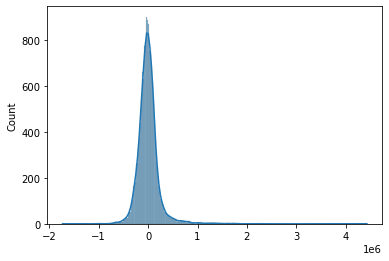

In [54]:
# histogram of model residuals
sns.histplot(model.resid, kde=True);

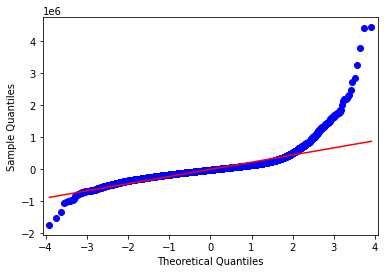

In [55]:
# qq-plot of model residuals
fig = sm.graphics.qqplot(model.resid,line='s')
plt.show()

From both the histogram and the qq-plot, we can see that the model residuals are not normally distributed, thus we cannot treat it as a valid model. While considering the assumptions, we should look at the distribution of residuals versus predicted values, to see if there is any insight to be gained there.

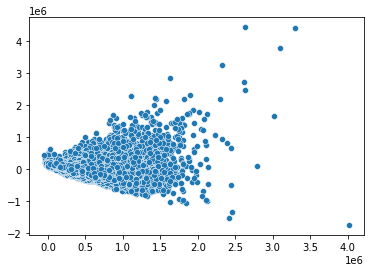

In [56]:
# plot residuals vs predicted values
sns.scatterplot(model.fittedvalues,model.resid);

We can see from the scatterplot above that the variance of the residuals increases with predicted values, violating the assumption of homoscedasticity. While there are quantitative tests we can use to determine whether the conditions are indeed violated, the visuals above are enough to make us re-visit the model and make adjustments.

In both cases, the violated assumptions are consistent with a non-normally distributed independent variable. When looking at the histogram of sale prices during data analysis, we noted that the values did not appear to be normally distributed and that it could cause issue when constructing a linear model. This appears to be true, so now we turn to the log transformation of sale prices as a potentially better response variable in the model.

In doing so, we'll repeat the same iterative process as before.

In [57]:
# MODEL 11: log_price ~ sqft_living
formula = 'log_price ~ sqft_living' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                 2.010e+04
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:01:51   Log-Likelihood:                -9634.6
No. Observations:               21533   AIC:                         1.927e+04
Df Residuals:                   21531   BIC:                         1.929e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2190      0.006   1911.732      0.000      12.206      12.232
sqft_living     0.0004   2.81e-06    141.760      0.000       0.000       0.000
==============================================================================
Omnibus:                        3.672   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.159   Jarque-Bera (JB):                3.693
Skew:                           0.029   Prob(JB):                        0.158
Kurtosis:                       2.974   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
# MODEL 12: log_price ~ sqft_living + bedrooms
formula_12 = 'log_price ~ sqft_living + bedrooms' 
model_12 = ols(formula=formula_12, data=df_new).fit()
model_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                 1.029e+04
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:01:53   Log-Likelihood:                -9511.8
No. Observations:               21533   AIC:                         1.903e+04
Df Residuals:                   21530   BIC:                         1.905e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.3384      0.010   1245.717      0.000      12.319      12.358
sqft_living     0.0004   3.47e-06    124.120      0.000       0.000       0.000
bedrooms       -0.0554      0.004    -15.714      0.000      -0.062      -0.048
==============================================================================
Omnibus:                        4.624   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.099   Jarque-Bera (JB):                4.758
Skew:                           0.016   Prob(JB):                       0.0927
Kurtosis:                       3.065   Cond. No.                     9.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
# MODEL 13: log_price ~ sqft_living + bedrooms + bathrooms
formula_13 = 'log_price ~ sqft_living + bedrooms + bathrooms' 
model_13 = ols(formula=formula_13, data=df_new).fit()
model_13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     6931.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:29:55   Log-Likelihood:                -9454.9
No. Observations:               21533   AIC:                         1.892e+04
Df Residuals:                   21529   BIC:                         1.895e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.3069      0.010   1193.783      0.000      12.287      12.327
sqft_living     0.0004   4.54e-06     88.008      0.000       0.000       0.000
bedrooms       -0.0611      0.004    -17.192      0.000      -0.068      -0.054
bathrooms       0.0549      0.005     10.682      0.000       0.045       0.065
==============================================================================
Omnibus:                        8.214   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.247
Skew:                           0.041   Prob(JB):                       0.0162
Kurtosis:                       3.050   Cond. No.                     9.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
# MODEL 14: log_price ~ sqft_living + bedrooms + bathrooms + floors
formula = 'log_price ~ sqft_living + bedrooms + bathrooms + floors' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     5251.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:29:55   Log-Likelihood:                -9401.1
No. Observations:               21533   AIC:                         1.881e+04
Df Residuals:                   21528   BIC:                         1.885e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2563      0.011   1077.172      0.000      12.234      12.279
sqft_living     0.0004   4.53e-06     88.298      0.000       0.000       0.000
bedrooms       -0.0573      0.004    -16.083      0.000      -0.064      -0.050
bathrooms       0.0321      0.006      5.753      0.000       0.021       0.043
floors          0.0571      0.006     10.384      0.000       0.046       0.068
==============================================================================
Omnibus:                       11.610   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.616
Skew:                           0.053   Prob(JB):                      0.00300
Kurtosis:                       3.041   Cond. No.                     1.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
# MODEL 15: log_price ~ sqft_living + bedrooms + bathrooms + floors + condition
formula_15 = 'log_price ~ sqft_living + bedrooms + bathrooms + floors + condition' 
model_15 = ols(formula=formula_15, data=df_new).fit()
model_15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     2756.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:29:56   Log-Likelihood:                -9139.2
No. Observations:               21533   AIC:                         1.830e+04
Df Residuals:                   21524   BIC:                         1.837e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 12.2007      0.012   1024.173      0.000      12.177      12.224
condition[T.Fair]         -0.1950      0.029     -6.798      0.000      -0.251      -0.139
condition[T.Good]          0.0737      0.006     12.030      0.000       0.062       0.086
condition[T.Poor]         -0.1629      0.069     -2.366      0.018      -0.298      -0.028
condition[T.Very Good]     0.1911      0.010     19.741      0.000       0.172       0.210
sqft_living                0.0004   4.48e-06     88.991      0.000       0.000       0.000
bedrooms                  -0.0628      0.004    -17.772      0.000      -0.070      -0.056
bathrooms                  0.0352      0.006      6.363      0.000       0.024       0.046
floors                     0.0824      0.006     14.667      0.000       0.071       0.093
==============================================================================
Omnibus:                       14.115   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.317
Skew:                           0.052   Prob(JB):                     0.000778
Kurtosis:                       3.071   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
# MODEL 16: log_price ~ sqft_living + bedrooms + bathrooms + floors + condition + sale_month
formula_16 = 'log_price ~ sqft_living + bedrooms + bathrooms + floors + condition + C(month)' 
model_16 = ols(formula=formula_16, data=df_new).fit()
model_16.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     1173.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:29:56   Log-Likelihood:                -9078.8
No. Observations:               21533   AIC:                         1.820e+04
Df Residuals:                   21513   BIC:                         1.836e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 12.1654      0.017    733.774      0.000      12.133      12.198
condition[T.Fair]         -0.1933      0.029     -6.749      0.000      -0.249      -0.137
condition[T.Good]          0.0745      0.006     12.186      0.000       0.063       0.086
condition[T.Poor]         -0.1563      0.069     -2.274      0.023      -0.291      -0.022
condition[T.Very Good]     0.1942      0.010     20.078      0.000       0.175       0.213
C(month)[T.2]              0.0117      0.016      0.742      0.458      -0.019       0.043
C(month)[T.3]              0.0708      0.015      4.847      0.000       0.042       0.099
C(month)[T.4]              0.0952      0.014      6.700      0.000       0.067       0.123
C(month)[T.5]              0.0464      0.014      3.308      0.001       0.019       0.074
C(month)[T.6]              0.0385      0.014      2.701      0.007       0.011       0.066
C(month)[T.7]              0.0213      0.014      1.500      0.134      -0.007       0.049
C(month)[T.8]              0.0238      0.015      1.635      0.102      -0.005       0.052
C(month)[T.9]              0.0190      0.015      1.286      0.198      -0.010       0.048
C(month)[T.10]             0.0210      0.015      1.439      0.150      -0.008       0.050
C(month)[T.11]             0.0089      0.015      0.580      0.562      -0.021       0.039
C(month)[T.12]             0.0035      0.015      0.228      0.820      -0.026       0.033
sqft_living                0.0004   4.47e-06     89.294      0.000       0.000       0.000
bedrooms                  -0.0630      0.004    -17.889      0.000      -0.070      -0.056
bathrooms                  0.0352      0.006      6.373      0.000       0.024       0.046
floors                     0.0829      0.006     14.784      0.000       0.072       0.094
==============================================================================
Omnibus:                       14.227   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.586
Skew:                           0.048   Prob(JB):                     0.000680
Kurtosis:                       3.083   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
# MODEL 17: log_price ~ sqft_living + bedrooms + bathrooms + floors + condition + sale_month + high_lat
formula_17 = 'log_price ~ sqft_living + bedrooms + bathrooms + floors + condition + C(month) + high_lat' 
model_17 = ols(formula=formula_17, data=df_new).fit()
model_17.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     2211.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:29:56   Log-Likelihood:                -4705.3
No. Observations:               21533   AIC:                             9453.
Df Residuals:                   21512   BIC:                             9620.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 11.7956      0.014    842.973      0.000      11.768      11.823
condition[T.Fair]         -0.1759      0.023     -7.524      0.000      -0.222      -0.130
condition[T.Good]          0.0991      0.005     19.852      0.000       0.089       0.109
condition[T.Poor]         -0.2089      0.056     -3.725      0.000      -0.319      -0.099
condition[T.Very Good]     0.1638      0.008     20.735      0.000       0.148       0.179
C(month)[T.2]              0.0227      0.013      1.762      0.078      -0.003       0.048
C(month)[T.3]              0.0718      0.012      6.023      0.000       0.048       0.095
C(month)[T.4]              0.0820      0.012      7.070      0.000       0.059       0.105
C(month)[T.5]              0.0300      0.011      2.618      0.009       0.008       0.052
C(month)[T.6]              0.0198      0.012      1.705      0.088      -0.003       0.043
C(month)[T.7]              0.0085      0.012      0.728      0.466      -0.014       0.031
C(month)[T.8]              0.0104      0.012      0.881      0.378      -0.013       0.034
C(month)[T.9]              0.0097      0.012      0.802      0.422      -0.014       0.033
C(month)[T.10]             0.0075      0.012      0.627      0.530      -0.016       0.031
C(month)[T.11]             0.0057      0.013      0.456      0.648      -0.019       0.030
C(month)[T.12]             0.0009      0.012      0.070      0.944      -0.024       0.025
sqft_living                0.0004   3.66e-06    100.447      0.000       0.000       0.000
bedrooms                  -0.0478      0.003    -16.600      0.000      -0.053      -0.042
bathrooms                  0.0572      0.005     12.691      0.000       0.048       0.066
floors                     0.0592      0.005     12.915      0.000       0.050       0.068
high_lat                   0.5000      0.005    103.829      0.000       0.491       0.509
==============================================================================
Omnibus:                      662.901   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1793.155
Skew:                           0.029   Prob(JB):                         0.00
Kurtosis:                       4.413   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
# MODEL 18: log_price ~ sqft_living + bedrooms + bathrooms + floors + condition + sale_month + high_lat + view
formula_18 = 'log_price ~ sqft_living + bedrooms + bathrooms + floors + condition + C(month) + high_lat + view' 
model_18 = ols(formula=formula_18, data=df_new).fit()
model_18.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     2021.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:29:56   Log-Likelihood:                -4023.6
No. Observations:               21533   AIC:                             8097.
Df Residuals:                   21508   BIC:                             8297.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 11.9548      0.017    717.448      0.000      11.922      11.987
condition[T.Fair]         -0.1754      0.023     -7.743      0.000      -0.220      -0.131
condition[T.Good]          0.0904      0.005     18.665      0.000       0.081       0.100
condition[T.Poor]         -0.2434      0.054     -4.478      0.000      -0.350      -0.137
condition[T.Very Good]     0.1506      0.008     19.649      0.000       0.136       0.166
C(month)[T.2]              0.0214      0.013      1.712      0.087      -0.003       0.046
C(month)[T.3]              0.0708      0.012      6.127      0.000       0.048       0.093
C(month)[T.4]              0.0828      0.011      7.371      0.000       0.061       0.105
C(month)[T.5]              0.0323      0.011      2.908      0.004       0.011       0.054
C(month)[T.6]              0.0222      0.011      1.967      0.049    7.69e-05       0.044
C(month)[T.7]              0.0127      0.011      1.129      0.259      -0.009       0.035
C(month)[T.8]              0.0132      0.011      1.147      0.252      -0.009       0.036
C(month)[T.9]              0.0097      0.012      0.831      0.406      -0.013       0.033
C(month)[T.10]             0.0080      0.012      0.696      0.487      -0.015       0.031
C(month)[T.11]             0.0081      0.012      0.669      0.503      -0.016       0.032
C(month)[T.12]             0.0040      0.012      0.331      0.741      -0.020       0.028
view[T.EXCELLENT]          0.3149      0.019     16.561      0.000       0.278       0.352
view[T.FAIR]               0.0488      0.019      2.621      0.009       0.012       0.085
view[T.GOOD]               0.0875      0.016      5.449      0.000       0.056       0.119
view[T.NONE]              -0.1636      0.010    -16.673      0.000      -0.183      -0.144
sqft_living                0.0003   3.65e-06     91.619      0.000       0.000       0.000
bedrooms                  -0.0353      0.003    -12.553      0.000      -0.041      -0.030
bathrooms                  0.0554      0.004     12.674      0.000       0.047       0.064
floors                     0.0704      0.004     15.810      0.000       0.062       0.079
high_lat                   0.4945      0.005    105.880      0.000       0.485       0.504
==============================================================================
Omnibus:                      815.645   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2330.568
Skew:                          -0.117   Prob(JB):                         0.00
Kurtosis:                       4.594   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix

In [62]:
# MODEL 19: log_price ~ sqft_living + bedrooms + bathrooms + floors + condition + high_lat + view
formula_19 = 'log_price ~ sqft_living + bedrooms + bathrooms + floors + condition + high_lat + view' 
model_19 = ols(formula=formula_19, data=df_new).fit()
model_19.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     3691.
Date:                Sat, 10 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:29:56   Log-Likelihood:                -4109.1
No. Observations:               21533   AIC:                             8246.
Df Residuals:                   21519   BIC:                             8358.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 11.9842      0.014    854.854      0.000      11.957      12.012
condition[T.Fair]         -0.1757      0.023     -7.736      0.000      -0.220      -0.131
condition[T.Good]          0.0893      0.005     18.381      0.000       0.080       0.099
condition[T.Poor]         -0.2490      0.055     -4.565      0.000      -0.356      -0.142
condition[T.Very Good]     0.1467      0.008     19.108      0.000       0.132       0.162
view[T.EXCELLENT]          0.3147      0.019     16.490      0.000       0.277       0.352
view[T.FAIR]               0.0482      0.019      2.578      0.010       0.012       0.085
view[T.GOOD]               0.0868      0.016      5.387      0.000       0.055       0.118
view[T.NONE]              -0.1648      0.010    -16.736      0.000      -0.184      -0.146
sqft_living                0.0003   3.67e-06     91.130      0.000       0.000       0.000
bedrooms                  -0.0348      0.003    -12.351      0.000      -0.040      -0.029
bathrooms                  0.0552      0.004     12.589      0.000       0.047       0.064
floors                     0.0698      0.004     15.621      0.000       0.061       0.079
high_lat                   0.4945      0.005    105.562      0.000       0.485       0.504
==============================================================================
Omnibus:                      792.183   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2237.172
Skew:                          -0.111   Prob(JB):                         0.00
Kurtosis:                       4.563   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
# MODEL 20: log_price ~ sqft_living + bathrooms + floors + condition + high_lat + view
formula_20 = 'log_price ~ sqft_living + bathrooms + floors + C(condition) + C(high_lat) + C(view)' 
model_20 = ols(formula=formula_20, data=df_new).fit()
model_20.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     3958.
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:02:03   Log-Likelihood:                -4185.2
No. Observations:               21533   AIC:                             8396.
Df Residuals:                   21520   BIC:                             8500.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    11.9193      0.013    913.889      0.000      11.894      11.945
C(condition)[T.Fair]         -0.1742      0.023     -7.641      0.000      -0.219      -0.129
C(condition)[T.Good]          0.0852      0.005     17.521      0.000       0.076       0.095
C(condition)[T.Poor]         -0.2436      0.055     -4.450      0.000      -0.351      -0.136
C(condition)[T.Very Good]     0.1415      0.008     18.384      0.000       0.126       0.157
C(high_lat)[T.1]              0.4972      0.005    105.900      0.000       0.488       0.506
C(view)[T.EXCELLENT]          0.3272      0.019     17.106      0.000       0.290       0.365
C(view)[T.FAIR]               0.0479      0.019      2.549      0.011       0.011       0.085
C(view)[T.GOOD]               0.0914      0.016      5.656      0.000       0.060       0.123
C(view)[T.NONE]              -0.1712      0.010    -17.350      0.000      -0.191      -0.152
sqft_living                   0.0003   3.43e-06     92.637      0.000       0.000       0.000
bathrooms                     0.0455      0.004     10.509      0.000       0.037       0.054
floors                        0.0744      0.004     16.664      0.000       0.066       0.083
==============================================================================
Omnibus:                      722.840   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1946.624
Skew:                          -0.099   Prob(JB):                         0.00
Kurtosis:                       4.459   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Again we have a model that satisfies our goals: high R^2, all statistically significant variables, and coefficients that sense - even if in need of different interpretation. Again, we should check the assumptions of normal linear regression to make sure the model is suitable. 

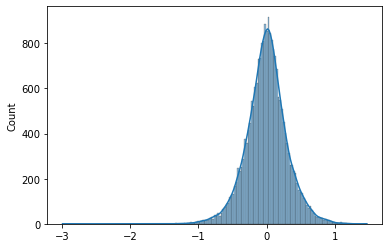

In [61]:
# histogram of model residuals
sns.histplot(model_20.resid, kde=True);

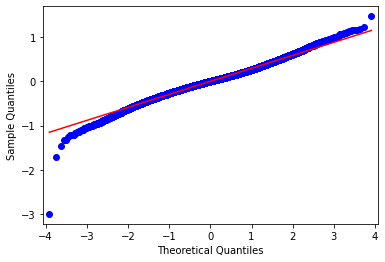

In [62]:
# qq-plot of model residuals
fig = sm.graphics.qqplot(model_20.resid,line='s')
plt.show()

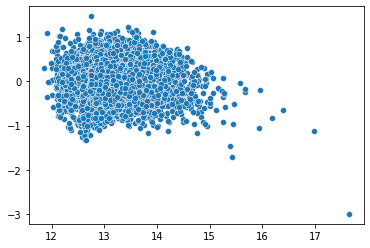

In [63]:
# plot residuals vs predicted values
sns.scatterplot(model_20.fittedvalues,model_20.resid);

While the assumption of normality appears to be much improved, there are still some outlying residuals and heterscedasticity that mean we cannot take the model as is.

In order to confront the existing issue in the model, we should incorporate a log transformation of the square footage variable, which we also saw to be non-normally distributed in the data analysis above.

In [64]:
# MODEL 21: log_price ~ log_sqft_living + bathrooms 
formula_21 = 'log_price ~ log_sqft_living + bathrooms + floors + C(condition) + C(high_lat) + C(view) + C(quarter)' 
model_21 = ols(formula=formula_21, data=df_new).fit()
model_21.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     3107.
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:02:11   Log-Likelihood:                -4325.1
No. Observations:               21533   AIC:                             8682.
Df Residuals:                   21517   BIC:                             8810.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     7.5141      0.052    143.681      0.000       7.412       7.617
C(condition)[T.Fair]         -0.1269      0.023     -5.525      0.000      -0.172      -0.082
C(condition)[T.Good]          0.0783      0.005     15.976      0.000       0.069       0.088
C(condition)[T.Poor]         -0.1729      0.055     -3.137      0.002      -0.281      -0.065
C(condition)[T.Very Good]     0.1341      0.008     17.299      0.000       0.119       0.149
C(high_lat)[T.1]              0.5161      0.005    109.310      0.000       0.507       0.525
C(view)[T.EXCELLENT]          0.3933      0.019     20.463      0.000       0.356       0.431
C(view)[T.FAIR]               0.0384      0.019      2.030      0.042       0.001       0.075
C(view)[T.GOOD]               0.1112      0.016      6.839      0.000       0.079       0.143
C(view)[T.NONE]              -0.1907      0.010    -19.235      0.000      -0.210      -0.171
C(quarter)[T.2]               0.0074      0.006      1.255      0.209      -0.004       0.019
C(quarter)[T.3]              -0.0269      0.006     -4.461      0.000      -0.039      -0.015
C(quarter)[T.4]              -0.0298      0.006     -4.714      0.000      -0.042      -0.017
log_sqft_living               0.6739      0.007     90.192      0.000       0.659       0.688
bathrooms                     0.0482      0.004     10.993      0.000       0.040       0.057
floors                        0.0664      0.004     14.762      0.000       0.058       0.075
==============================================================================
Omnibus:                      357.960   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              657.274
Skew:                           0.102   Prob(JB):                    1.88e-143
Kurtosis:                       3.831   Cond. No.                         224.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

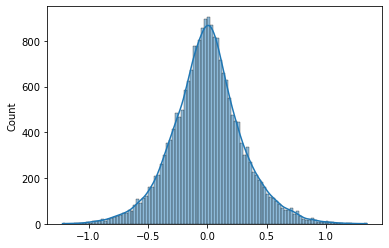

In [65]:
# histogram of model residuals
sns.histplot(model_21.resid, kde=True);

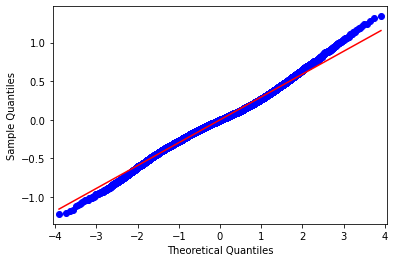

In [66]:
# qq-plot of model residuals
fig = sm.graphics.qqplot(model_21.resid,line='s')
plt.show()

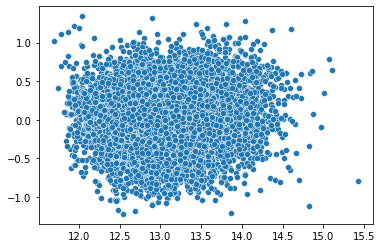

In [67]:
# plot residuals vs predicted values
sns.scatterplot(model_21.fittedvalues,model_21.resid);

Finally, a model consistent with the linear model assumptions: normally distributed residuals and apparent homoscedasticity. Now that we have a model that meets the criteria for inferential purposes and meets the assumptions for linear models, we can proceed to make suggestions to a real estate investor.

## Interpretation of Coefficients

Since the model is an inferential one, we can look to the coefficients for independent variables to explain how a change in an independent variable (which is what an individual real estate investor ultimately wants to do) will affect the sale price of a home. Since the model uses a log transformation on the dependent variable, however, the interpretation of the coefficients will require a further step of un-transforming, so to speak.

In [70]:
# print coefficients
model_21.params

Intercept                    7.514076
C(condition)[T.Fair]        -0.126862
C(condition)[T.Good]         0.078332
C(condition)[T.Poor]        -0.172877
C(condition)[T.Very Good]    0.134105
C(high_lat)[T.1]             0.516093
C(view)[T.EXCELLENT]         0.393255
C(view)[T.FAIR]              0.038362
C(view)[T.GOOD]              0.111224
C(view)[T.NONE]             -0.190703
C(quarter)[T.2]              0.007364
C(quarter)[T.3]             -0.026922
C(quarter)[T.4]             -0.029803
log_sqft_living              0.673851
bathrooms                    0.048162
floors                       0.066372
dtype: float64

In [71]:
# latitude
high_lat_multiplier = np.exp(model_21.params['C(high_lat)[T.1]'])
print("high latitude multiplier:",round(high_lat_multiplier,2))

high latitude multiplier: 1.68


The coefficient for a home being in the northern half of our property range suggests that should the same home be moved from the southern half to the northern half of the county (which is obviously impossible), the home price will be approximately 1.68 times higher! This is not surprising considering our original analysis, but it is noteworthy.

In [72]:
# view
view_excellent = np.exp(model_21.params['C(view)[T.EXCELLENT]'])
print("view from average to excellent:",round(view_excellent,2))

view_fair = np.exp(model_21.params['C(view)[T.FAIR]'])
print("view from average to fair:",round(view_fair,2))

view_good = np.exp(model_21.params['C(view)[T.GOOD]'])
print("view from average to good:",round(view_good,2))

view_none = np.exp(model_21.params['C(view)[T.NONE]'])
print("view from average to none:",round(view_none,2))

view from average to excellent: 1.48
view from average to fair: 1.04
view from average to good: 1.12
view from average to none: 0.83


In [73]:
# month
sale_q2 = np.exp(model_21.params['C(quarter)[T.2]'])
print("sale from 1st quarter to 2nd quarter:",round(sale_q2,2))

sale_q3 = np.exp(model_21.params['C(quarter)[T.3]'])
print("sale from 1st quarter to 3rd quarter:",round(sale_q3,2))

sale_q4 = np.exp(model_21.params['C(quarter)[T.4]'])
print("sale from 1st quarter to 4th quarter:",round(sale_q4,2))

sale from 1st quarter to 2nd quarter: 1.01
sale from 1st quarter to 3rd quarter: 0.97
sale from 1st quarter to 4th quarter: 0.97


In [74]:
# condition
condition_fair = np.exp(model_21.params['C(condition)[T.Fair]'])
print("condition from average to fair:",round(condition_fair,2))

condition_good = np.exp(model_21.params['C(condition)[T.Good]'])
print("condition from average to good:",round(condition_good,2))

condition_poor = np.exp(model_21.params['C(condition)[T.Poor]'])
print("condition from average to poor:",round(condition_poor,2))

condition_very_good = np.exp(model_21.params['C(condition)[T.Very Good]'])
print("condition from average to very good:",round(condition_very_good,2))

condition from average to fair: 0.88
condition from average to good: 1.08
condition from average to poor: 0.84
condition from average to very good: 1.14


In [75]:
# floors
floors_multiplier = np.exp(model_21.params['floors'])
print("floors multiplier:",round(floors_multiplier,2))

floors multiplier: 1.07


In [76]:
# bathrooms
bathrooms_multiplier = np.exp(model_21.params['bathrooms'])
print("bathrooms multiplier:",round(bathrooms_multiplier,2))

bathrooms multiplier: 1.05


In [77]:
# square footage
sqft_multiplier = 1.01**model_21.params['log_sqft_living']
print("square footage multiplier:",round(sqft_multiplier,2))

square footage multiplier: 1.01


The square footage multiplier of 1.01 suggests that increasing the square footage of a home by 1% yields an increase in sale price of 1%. From an investor's point of view, this is highly useful, because if you can increase square footage for less than the cost of the home, then you can cheaply increase the value of the home.

## Recommendations

From the coefficients of the independent variables in the model, we can make several recommendations to an individual real estate investor. However, in order to do so, we need to make some assumptions about this investor, the primary being one that he or she will purchase a home at a price up to, but not above, the median sale price of the market as represented by the data set. 

In [78]:
# median sale price
median_sale_price = np.median(df_new['price'])
print("Median sale price:",median_sale_price)

# median square footage
median_sqft_living = np.median(df_new['sqft_living'])
print("Median square footage of living space:",median_sqft_living)

# median model implied price of average square footage home
median_model_price = np.exp(model_21.params['Intercept']+model_21.params['log_sqft_living']*np.log(median_sqft_living))
print("Model price of median square foot home:",round(median_model_price,2))

Median sale price: 450000.0
Median square footage of living space: 1910.0
Model price of median square foot home: 298023.78


### Recommendation 1: Buy a house in the southern section of the market that has no view

In [155]:
# calculate multiplier going from high latitude to low latitude
low_lat_multiplier = 1/high_lat_multiplier
print("Low-latitude percentage of same home:",round(low_lat_multiplier,2))

# calculate multiplier going from average view to no view
no_view_multiplier = 1/view_none - 1
print("No view percentage of same home",round(no_view_multiplier,2))

# total multiplier
print("Total combined discount:",round(1-low_lat_multiplier*no_view_multiplier,2))

Low-latitude percentage of same home: 0.6
No view percentage of same home 0.21
Total combined discount: 0.87


Based on the model coefficients, a house with the same specifications in the southern half of the data set should be worth about 60% less than the equivalent house in the northern half. Moreover, a house with no view should be worth about 21% less than the equivalent house (anywhere) with an average view. Assuming neither of these attributes can be changed, combining these factors gets the investor a roughly 87% discount.

In [84]:
# create sub dataframe for properties that meet recommendation 1
df_new_rec_1 = df_new[(df_new['high_lat']==0) & (df_new['view'] == 'NONE')]

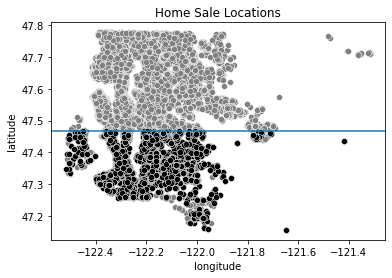

In [93]:
# plot properties that qualify for recommendation 1 against all properties
sns.scatterplot(df_new['long'],df_new['lat'],color='grey')
sns.scatterplot(df_new_rec_1['long'],df_new_rec_1['lat'],color='black')
plt.axhline(mid_lat)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Home Sale Locations');

### Recommendation 2: Buy poor or fair condition homes and look to upgrade them to average condition

poor to average: 0.19
fair to average: 0.14


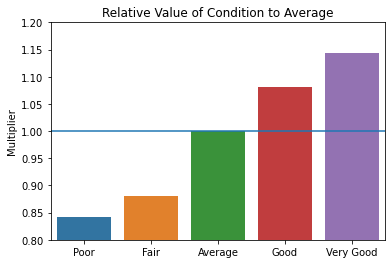

In [108]:
# calculate multiplier going from poor to average
poor_to_average = 1/condition_poor-1
print("poor to average:",round(poor_to_average,2))

# calculate multiplier going from fair to average
fair_to_average = 1/condition_fair-1
print("fair to average:",round(fair_to_average,2))

# create lists for bar plot
conditions = ['Poor','Fair','Average','Good','Very Good']
multipliers = [condition_poor,condition_fair,1.0,condition_good,condition_very_good]

# create barplot
fig,ax=plt.subplots()
sns.barplot(x=conditions,y=multipliers)
ax.set_ylim(0.8,1.2)
plt.axhline(1.0)
plt.ylabel('Multiplier')
plt.title('Relative Value of Condition to Average');

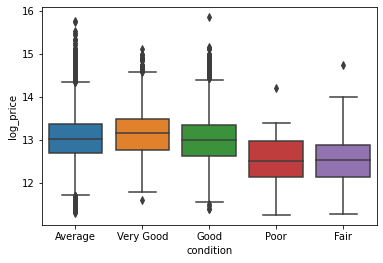

In [147]:
# boxplot of price vs condition
sns.boxplot(df_new['condition'],df_new['log_price']);

### Recommendation 3: Only add another bathroom in the case of low cost purchases (or to improve condition)

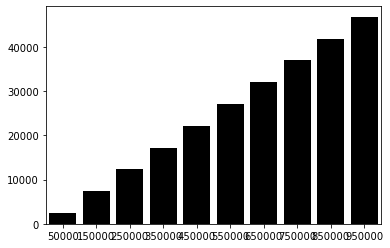

In [142]:
# according to HomeAdvisor, average cost of new bathroom in existing space is $15,000
# source: https://www.homeadvisor.com/cost/bathrooms/#average-cost-of-adding-a-bathroom

bathroomCosts = [5000,15000,35000]
costTypes = ['Low','Average','High']

homeValues = np.arange(50000,1000000,100000)
bathroomValues = np.array(homeValues)*(bathrooms_multiplier-1)

sns.barplot(homeValues,bathroomValues,color='black');

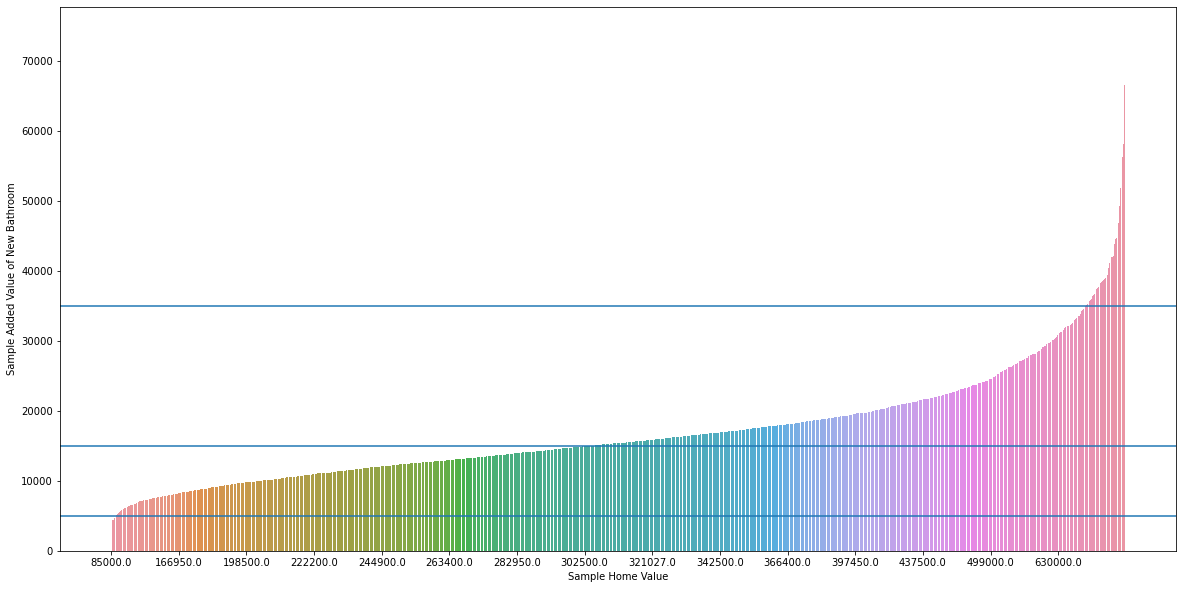

In [150]:
sample_home_prices = np.array(df_new_rec_1['price'])
sample_bathroom_values = sample_home_prices*(bathrooms_multiplier-1)

fig,ax = plt.subplots(figsize=(20,10))
sns.barplot(sample_home_prices,sample_bathroom_values)
plt.locator_params(axis='x', nbins=15)
plt.xlabel('Sample Home Value')
plt.ylabel('Sample Added Value of New Bathroom')
plt.axhline(bathroomCosts[0])
plt.axhline(bathroomCosts[1])
plt.axhline(bathroomCosts[2]);